In [ ]:
# Mount Google Drive and Change Dir
from google.colab import drive
drive.mount('gdrive')

%cd gdrive/My\ Drive/Colab\ Notebooks/Fantasy_Football

In [ ]:
import numpy as np
import pandas as pd

rushing_df = pd.read_csv('Rushing.csv')
rushing_adv_df = pd.read_csv('Rushing_adv.csv')
receiving_df = pd.read_csv('Receiving.csv')
receiving_adv_df = pd.read_csv('Receiving_adv.csv')

# RB Analysis

We'll be looking at RB stats from the 2019-20 NFL season and analyze individual playstyle/tendencies according to performance.

## Rushing Stats

The following are rushing stats of eligible RBs (40 Primary/Part-time starters according to Pro-Football-Reference)

In [ ]:
# Merge advanced rushing stats and filter eligible RBs only (40 Players)
rushing_add_1 = rushing_df[rushing_df['Pos'].str.lower()=='rb']
rushing_add_2 = rushing_adv_df.drop(['Rk', 'Tm', 'Age', 'Pos', 'G', 'GS', 'Att', '1D', 'Yds'], axis=1)
rushing_new = rushing_add_1.merge(rushing_add_2, how='left', on=['Player'])

# Remove rank column and edit player names
rushing_new.drop('Rk', axis=1, inplace=True)
rushing_new['Player'] = rushing_new['Player'].str.split('\\').str[0]
rushing_new.head()

,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb,YBC,YBC/Att,YAC,YAC/Att,BrkTkl,Att/Br
0,Derrick Henry,TEN,25,RB,15,15,303,1540,16,73,74,5.1,102.7,5,572,1.9,968,3.2,29,10.4
1,Ezekiel Elliott,DAL,24,RB,16,16,301,1357,12,78,33,4.5,84.8,3,678,2.3,679,2.3,24,12.5
2,Nick Chubb,CLE,24,RB,16,16,298,1494,8,62,88,5.0,93.4,3,612,2.1,882,3.0,32,9.3
3,Christian McCaffrey,CAR,23,RB,16,16,287,1387,15,57,84,4.8,86.7,1,874,3.0,513,1.8,16,17.9
4,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,4.4,82.0,7,496,1.8,734,2.6,28,9.9


We have selected the following 5 features to best represent each RB's rushing playstyle from this past season. Notice TDs have been excluded.

- **Y/A** : Yards per Attempt
- **YBC/Att** : Yards Before Contact per Attempt (Carry)
- **YAC/Att** : Yards After Contact per Attempt (Carry)
- **Att/Br** : Attempts (Carries) for every Broken Tackle
- **Att/G** : Attempts (Carries) per Game

In [ ]:
# Extract rushing stats of importance (EXCLUDE TDs)
rushing_only = rushing_new.copy()[['Y/A', 'YBC/Att', 'YAC/Att', 'Att/Br']]
rushing_only['Att/G'] = rushing_new['Att']/rushing_new['G']
rushing_only.describe()

,Y/A,YBC/Att,YAC/Att,Att/Br,Att/G
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,4.195000,2.050000,2.150000,15.422500,13.478304
std,0.657871,0.510907,0.510907,10.973639,3.992530
min,1.800000,0.700000,1.100000,5.900000,4.000000
25%,3.775000,1.800000,1.800000,10.275000,10.303977
50%,4.350000,2.050000,2.150000,12.900000,14.033333
75%,4.600000,2.400000,2.425000,16.975000,16.862981
max,5.100000,3.300000,3.200000,74.000000,20.200000


### Perform PCA to determine the optimal number of components

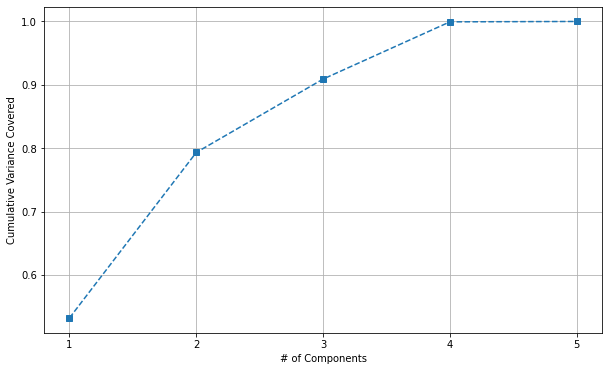

Total variance explained at n_components=2: 0.7932
Total variance explained at n_components=3: 0.9091


In [ ]:
# PCA for Dimension Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
pca = PCA()

# Scale rushing stats before PCA
scaler.fit(rushing_only)
rushing_only_scaled = scaler.transform(rushing_only)

pca.fit(rushing_only_scaled)
x_val = list(range(1, len(pca.explained_variance_ratio_)+1))

plt.figure(figsize=(10, 6))
plt.plot(x_val, np.cumsum(pca.explained_variance_ratio_), '--s')
plt.xticks(np.arange(min(x_val), max(x_val)+1, 1.0))
plt.xlabel('# of Components')
plt.ylabel('Cumulative Variance Covered')
plt.grid(True)
plt.show()

print('Total variance explained at n_components=2: {:.4f}'.format(np.sum(pca.explained_variance_ratio_[:2])))
print('Total variance explained at n_components=3: {:.4f}'.format(np.sum(pca.explained_variance_ratio_[:3])))

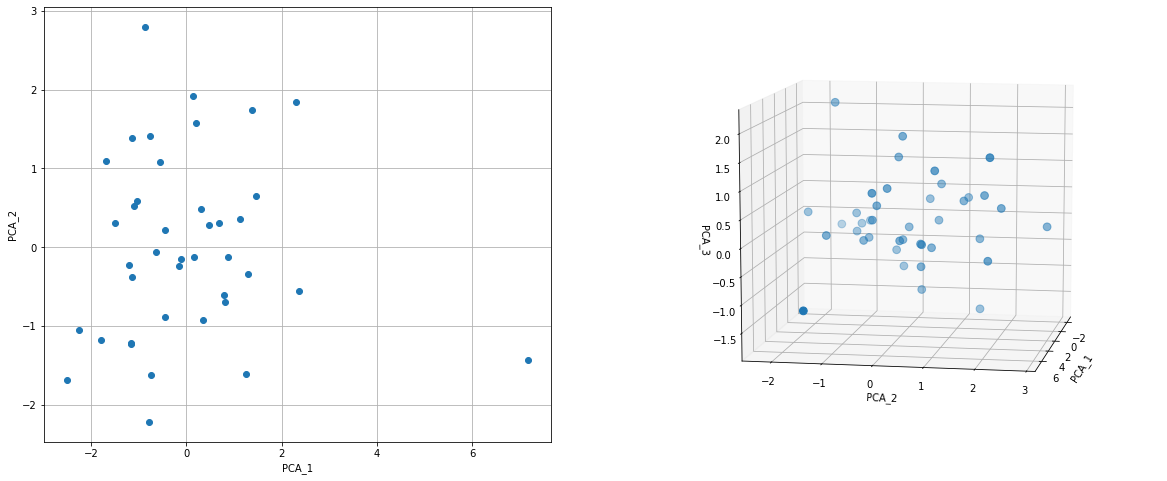

In [ ]:
# PCA Plots
rush_pca_2 = PCA(n_components=2).fit_transform(rushing_only_scaled)
rush_pca_3 = PCA(n_components=3).fit_transform(rushing_only_scaled)
rush_pca_2_df = pd.DataFrame(rush_pca_2, columns=['PCA_1', 'PCA_2'])
rush_pca_3_df = pd.DataFrame(rush_pca_3, columns=['PCA_1', 'PCA_2', 'PCA_3'])

fig = plt.figure(figsize=(20, 8))

# n_components=2
ax = fig.add_subplot(1, 2, 1)
ax.scatter(rush_pca_2_df['PCA_1'], rush_pca_2_df['PCA_2'])
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.grid(True)

# n_components=3
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(rush_pca_3_df['PCA_1'], rush_pca_3_df['PCA_2'], rush_pca_3_df['PCA_3'], cmap="Set2_r", s=60)
ax.view_init(10, 10)
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')

plt.show()

### We can determine the ideal number of clusters with Silhouette Analysis

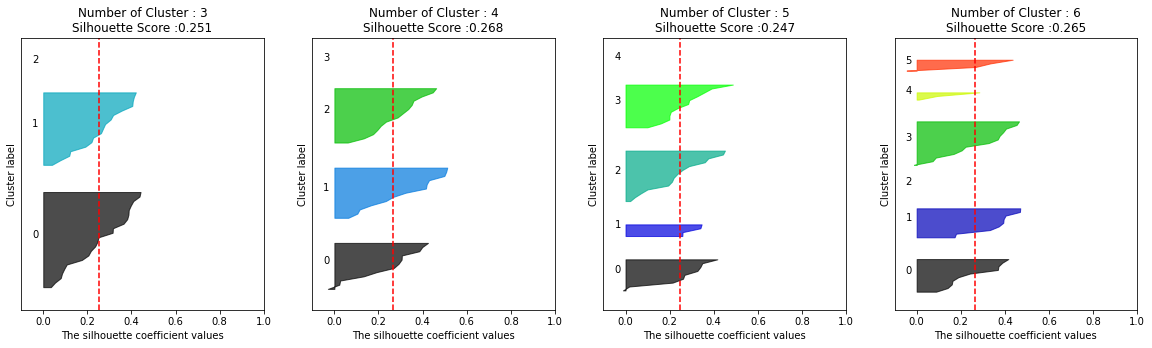

In [ ]:
# Silhouette Visualization fucntion
def visualize_silhouette(cluster_list, X_features):
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_samples, silhouette_score
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  # Number of Silhouette Scores to plot
  n_cols = len(cluster_list)
  fig, axs = plt.subplots(figsize=(5*n_cols, 5), nrows=1, ncols=n_cols)
  
  # iterate through the n_clusters list and visualize for each selection
  for ind, n_cluster in enumerate(cluster_list):
    clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
    cluster_labels = clusterer.fit_predict(X_features)
    sil_avg = silhouette_score(X_features, cluster_labels)
    sil_values = silhouette_samples(X_features, cluster_labels)
    y_lower = 5
    axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' 'Silhouette Score :' + str(round(sil_avg,3)))
    axs[ind].set_xlabel("The silhouette coefficient values")
    axs[ind].set_ylabel("Cluster label")
    axs[ind].set_xlim([-0.1, 1])
    axs[ind].set_ylim([0, len(X_features) + ((n_cluster + 1) * 5)])
    axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
    axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # plot using fill_betweenx() for each cluster
    for i in range(n_cluster):
      ith_cluster_sil_values = sil_values[cluster_labels==i]
      ith_cluster_sil_values.sort()
      size_cluster_i = ith_cluster_sil_values.shape[0]
      y_upper = y_lower + size_cluster_i
      color = cm.nipy_spectral(float(i) / n_cluster)
      axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
      axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 5
    axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
  
visualize_silhouette([3, 4, 5, 6], rushing_only_scaled)

### With n_clusters=4, these are the "average playstyles" for each cluster formed

In [ ]:
# Find cluster centers
from sklearn.cluster import KMeans

kmeans_rush = KMeans(n_clusters=4, max_iter=500)
kmeans_rush.fit(rushing_only_scaled)
cluster_avg = pd.DataFrame(scaler.inverse_transform(kmeans_rush.cluster_centers_), columns=rushing_only.columns)
cluster_avg

,Y/A,YBC/Att,YAC/Att,Att/Br,Att/G
0,4.640000,2.680000,1.950000,13.400000,11.881410
1,3.678571,1.800000,1.878571,14.642857,11.740080
2,4.540000,1.953333,2.606667,13.593333,16.652685
3,1.800000,0.700000,1.100000,74.000000,6.166667


We can observe that the elite RBs are identified in two distinct clusters **0** and **2**.

While both clusters share similar Yards per Attempt (Carry), **Cluster 0** shows fewer Attempts (Carries) per Game with greater Yards Before Contact per Attempt (Carry). The inverse is true for **Cluster 2**.

Thus, we can deduce that **Cluster 0** is comprised of players who are more elusive with strengths in speed and agility, while **Cluster 2** is comprised of power runners who are able to break tackles more often and gain yardage after initial contact by opposing players.


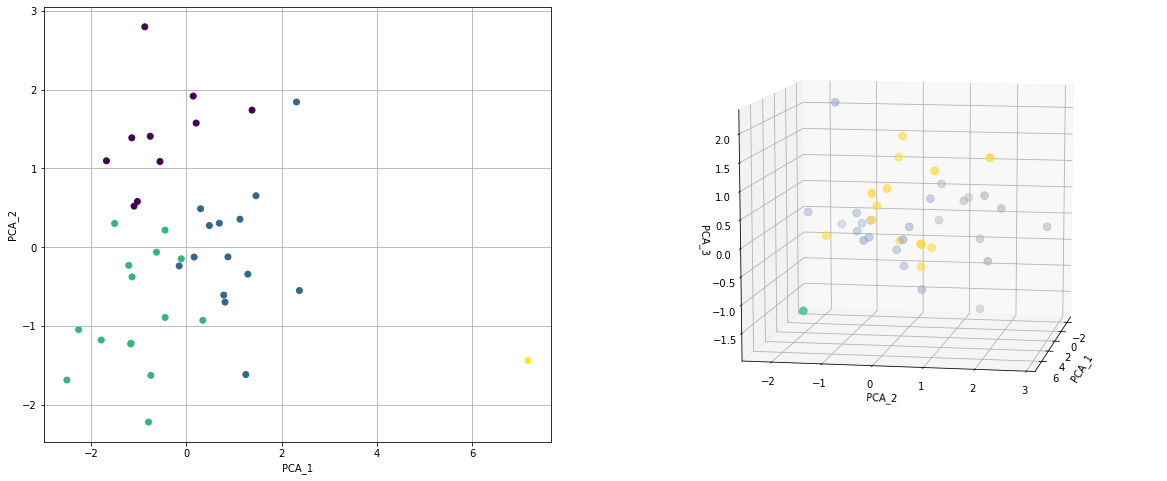

In [ ]:
# PCA Plots with labels
rush_pca_2_df['label'] = kmeans_rush.labels_
rush_pca_3_df['label'] = kmeans_rush.labels_

fig = plt.figure(figsize=(20, 8))

# n_components=2
ax = fig.add_subplot(1, 2, 1)
ax.scatter(rush_pca_2_df['PCA_1'], rush_pca_2_df['PCA_2'], c=rush_pca_2_df['label'])
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.grid(True)

# n_components=3
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(rush_pca_3_df['PCA_1'], rush_pca_3_df['PCA_2'], rush_pca_3_df['PCA_3'], c=rush_pca_3_df['label'], cmap="Set2_r", s=60)
ax.view_init(10, 10)
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')

plt.show()

## Receiving Stats

The following are receiving stats of eligible RBs (40 Primary/Part-time starters according to Pro-Football-Reference)

In [ ]:
# Merge advanced receiving stats and filter eligible RBs only (40 Players)
receiving_add_1 = receiving_df[receiving_df['Pos'].str.lower()=='rb']
receiving_add_2 = receiving_adv_df.drop(['Rk', 'Tm', 'Age', 'Pos', 'G', 'GS', 'Tgt', 'Rec', 'Yds', 'TD', '1D'], axis=1)
receiving_new = receiving_add_1.merge(receiving_add_2, how='left', on=['Player'])

# Remove rank column and edit player names
receiving_new.drop('Rk', axis=1, inplace=True)
receiving_new['Player'] = receiving_new['Player'].str.split('\\').str[0]
receiving_new.head()

,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,YBC,YBC/R,YAC,YAC/R,ADOT,BrkTkl,Rec/Br,Drop,Drop%,Int,Rat
0,Christian McCaffrey,CAR,23,RB,16,16,142,116,81.7%,1005,8.7,4,58,28,7.1,7.3,62.8,1,-14,-0.1,1019,8.8,0.6,14,8.3,7,4.9,2.0,99.7
1,Austin Ekeler,LAC,24,rb,16,8,108,92,85.2%,993,10.8,8,42,84,9.2,5.8,62.1,3,53,0.6,940,10.2,1.3,15,6.1,1,0.9,2.0,122.0
2,Alvin Kamara,NOR,24,RB,14,9,97,81,83.5%,533,6.6,1,28,41,5.5,5.8,38.1,4,-24,-0.3,557,6.9,0.3,10,8.1,5,5.2,1.0,88.7
3,Tarik Cohen,CHI,24,RB,16,11,104,79,76.0%,456,5.8,3,18,31,4.4,4.9,28.5,3,27,0.3,429,5.4,1.8,5,15.8,9,8.7,1.0,89.3
4,Leonard Fournette,JAX,24,RB,15,15,100,76,76.0%,522,6.9,0,23,27,5.2,5.1,34.8,1,-36,-0.5,558,7.3,0.1,8,9.5,6,6.0,1.0,83.0


We have selected the following 6 features to best represent each RB's receiving playstyle from this past season. Notice TDs have been excluded.

- **Y/R** : Yards per Reception
- **ADOT** : Average Depth of Target
- **YAC/R** : Yards After Catch per Reception 
- **Rec/Br** : Receptions for every Broken Tackle
- **R/G** : Receptions per Game
- **Rat** : Passer Rating

In [ ]:
# Extract receiving stats of importance (EXCLUDE TDs)
receiving_only = receiving_new.copy()[['Y/R', 'ADOT', 'YAC/R', 'Rec/Br', 'R/G', 'Rat']]
receiving_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y/R     40 non-null     float64
 1   ADOT    40 non-null     float64
 2   YAC/R   40 non-null     float64
 3   Rec/Br  34 non-null     float64
 4   R/G     40 non-null     float64
 5   Rat     40 non-null     float64
dtypes: float64(6)
memory usage: 2.2 KB


6 Players have missing values for Rec/Br => 6 Players have 0 broken tackles after reception

Assign column_max_val to handle missing values.

In [ ]:
# Missing Values 
receiving_only[receiving_only['Rec/Br'].isna()]

,Y/R,ADOT,YAC/R,Rec/Br,R/G,Rat
6,6.9,1.1,5.8,NaN,4.2,104.2
16,5.6,-1.5,6.9,NaN,2.2,79.9
27,8.6,-1.0,9.7,NaN,1.5,82.6
33,4.5,-0.3,6.2,NaN,1.2,45.8
34,5.9,-0.3,5.7,NaN,1.0,86.8
39,5.0,-2.0,8.0,NaN,0.2,39.6


In [ ]:
# Fill missing values with Rec/Br max_val
receiving_only['Rec/Br'].fillna(receiving_only['Rec/Br'].max(), inplace=True)
receiving_only.info()
receiving_only.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y/R     40 non-null     float64
 1   ADOT    40 non-null     float64
 2   YAC/R   40 non-null     float64
 3   Rec/Br  40 non-null     float64
 4   R/G     40 non-null     float64
 5   Rat     40 non-null     float64
dtypes: float64(6)
memory usage: 2.2 KB


,Y/R,ADOT,YAC/R,Rec/Br,R/G,Rat
count,40.000000,40.000000,40.00000,40.000000,40.00000,40.000000
mean,7.770000,0.370000,7.97250,12.485000,2.60500,93.602500
std,1.847132,1.513901,1.70384,9.734121,1.61895,22.153468
min,4.200000,-2.000000,5.10000,2.800000,0.20000,27.100000
25%,6.700000,-0.750000,6.70000,5.800000,1.45000,86.600000
50%,7.400000,0.550000,8.00000,8.550000,2.20000,92.950000
75%,8.625000,1.325000,8.80000,13.700000,3.42500,104.775000
max,12.700000,4.600000,12.70000,31.000000,7.30000,141.700000


### Perform PCA to determine the optimal number of components

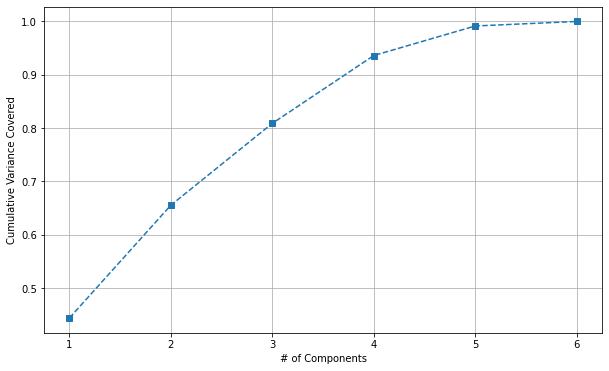

Total variance explained at n_components=2: 0.6554
Total variance explained at n_components=3: 0.8089


In [ ]:
# PCA for Dimension Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
pca = PCA()

# Scale receiving stats before PCA
scaler.fit(receiving_only)
receiving_only_scaled = scaler.transform(receiving_only)

pca.fit(receiving_only_scaled)
x_val = list(range(1, len(pca.explained_variance_ratio_)+1))

plt.figure(figsize=(10, 6))
plt.plot(x_val, np.cumsum(pca.explained_variance_ratio_), '--s')
plt.xticks(np.arange(min(x_val), max(x_val)+1, 1.0))
plt.xlabel('# of Components')
plt.ylabel('Cumulative Variance Covered')
plt.grid(True)
plt.show()

print('Total variance explained at n_components=2: {:.4f}'.format(np.sum(pca.explained_variance_ratio_[:2])))
print('Total variance explained at n_components=3: {:.4f}'.format(np.sum(pca.explained_variance_ratio_[:3])))

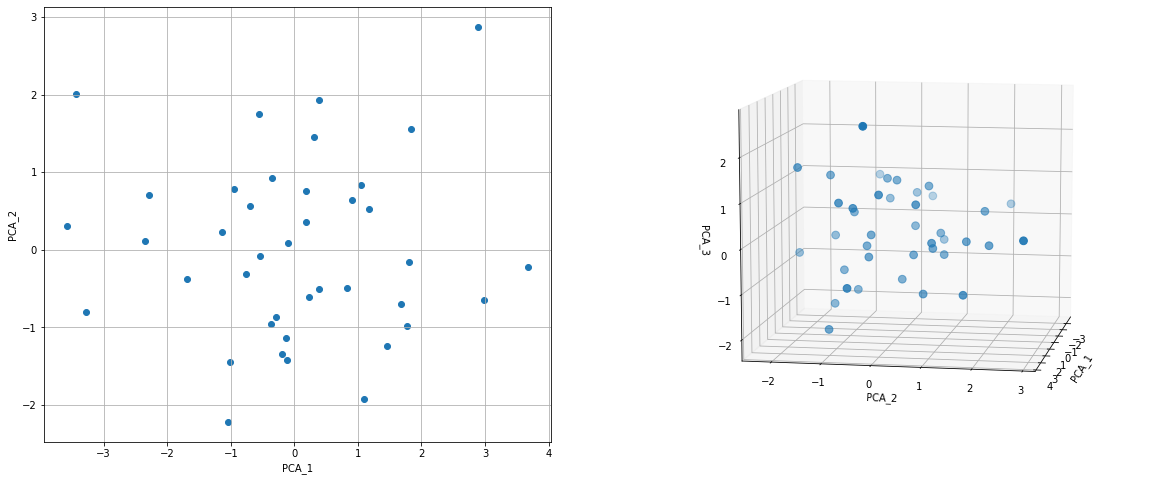

In [ ]:
# PCA Plots
rec_pca_2 = PCA(n_components=2).fit_transform(receiving_only_scaled)
rec_pca_3 = PCA(n_components=3).fit_transform(receiving_only_scaled)
rec_pca_2_df = pd.DataFrame(rec_pca_2, columns=['PCA_1', 'PCA_2'])
rec_pca_3_df = pd.DataFrame(rec_pca_3, columns=['PCA_1', 'PCA_2', 'PCA_3'])

fig = plt.figure(figsize=(20, 8))

# n_components=2
ax = fig.add_subplot(1, 2, 1)
ax.scatter(rec_pca_2_df['PCA_1'], rec_pca_2_df['PCA_2'])
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.grid(True)

# n_components=3
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(rec_pca_3_df['PCA_1'], rec_pca_3_df['PCA_2'], rec_pca_3_df['PCA_3'], cmap="Set2_r", s=60)
ax.view_init(10, 10)
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')

plt.show()

### We can determine the ideal number of clusters with Silhouette Analysis

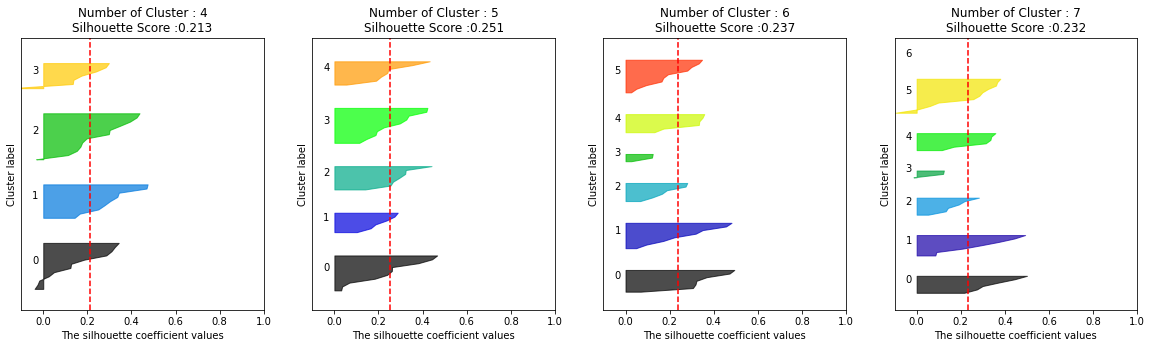

In [ ]:
# Silhouette Visualization fucntion
visualize_silhouette([4, 5, 6, 7], receiving_only_scaled)

### With n_clusters=5, these are the "average playstyles" for each cluster formed

In [ ]:
# Find cluster centers
from sklearn.cluster import KMeans

kmeans_rec = KMeans(n_clusters=5, max_iter=500)
kmeans_rec.fit(receiving_only_scaled)

print(np.unique(kmeans_rec.labels_, return_counts=True))

cluster_avg = pd.DataFrame(scaler.inverse_transform(kmeans_rec.cluster_centers_), columns=receiving_only.columns)
cluster_avg

(array([0, 1, 2, 3, 4], dtype=int32), array([7, 7, 9, 9, 8]))


,Y/R,ADOT,YAC/R,Rec/Br,R/G,Rat
0,6.757143,1.142857,6.657143,8.771429,1.242857,77.342857
1,10.457143,2.357143,9.014286,9.385714,2.814286,115.357143
2,8.366667,-1.155556,9.566667,5.922222,2.233333,102.522222
3,7.255556,0.533333,7.344444,8.222222,4.566667,94.322222
4,6.212500,-0.512500,7.125000,30.625000,1.825000,77.950000


We can observe that the elite RBs lie within the three clusters **1** , **2**, and **3**.

As expected, the quality of QB shows a positive correlation to reception yards; however, the remaining features provide further insight for each cluster.

ADOT (Average Depth of Target) sketches the possible scenarios in which the RBs receive their targets. **Cluster 1** shows the highest ADOT and moderately high R/G (Receptions per Game), hinting that these receptions were intended plays for the RBs running a short route (i.e. Angle/Corner). The Rec/Br (Receptions for every broken tackle) feature further supports the claim since the passing play would have been quickly picked up by the defense still intact, making it difficult for the RB to break incoming tackles.

Meanwhile, **Cluster 2** shows the lowest ADOT (Negative!) and the lowest R/G, hinting that these receptions were not intended and may have resulted from a blitz or the pocket breaking down, forcing the QB to keep the play alive with a negative yardage pass. Interestingly enough, the cluster shows the lowest Rec/Br and the highest YAC/R (Yards After Contact per Reception), implying that the defense was caught off guard by the pass and scrambling to bring down the RB.

Lastly, **Cluster 3** shows near-zero ADOT and the highest R/G, hinting that these receptions were most likely screen passes, designed for the RB to run behind his blockers. Yet, they show the lowest Y/R and YAC/R compared to the other clusters.

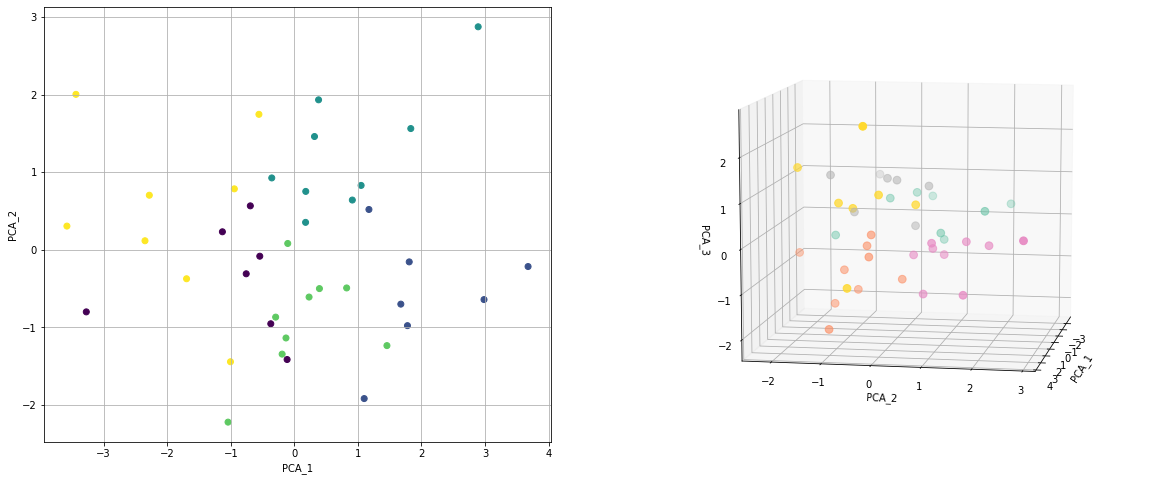

In [ ]:
# PCA Plots with labels
rec_pca_2_df['label'] = kmeans_rec.labels_
rec_pca_3_df['label'] = kmeans_rec.labels_

fig = plt.figure(figsize=(20, 8))

# n_components=2
ax = fig.add_subplot(1, 2, 1)
ax.scatter(rec_pca_2_df['PCA_1'], rec_pca_2_df['PCA_2'], c=rec_pca_2_df['label'])
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.grid(True)

# n_components=3
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(rec_pca_3_df['PCA_1'], rec_pca_3_df['PCA_2'], rec_pca_3_df['PCA_3'], c=rec_pca_3_df['label'], cmap="Set2_r", s=60)
ax.view_init(10, 10)
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')

plt.show()

## Cumulative Stats - Cluster Summation

In [ ]:
rush_w_label = rushing_new.copy()
rush_w_label['cluster'] = kmeans_rush.labels_

rec_w_label = receiving_new.copy()
rec_w_label['cluster'] = kmeans_rec.labels_

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print('Cluster 0 - "Elusive Running Backs" with more yards gained before contact')
  print(rush_w_label[rush_w_label['cluster'] == 0][['Player', 'Y/A', 'YBC/Att', 'YAC/Att', 'Att/Br', 'TD']])
  print('\nCluster 2 - "Power Runners" with more yards gained after contact')
  print(rush_w_label[rush_w_label['cluster'] == 2][['Player', 'Y/A', 'YBC/Att', 'YAC/Att', 'Att/Br', 'TD']])

Cluster 0 - "Elusive Running Backs" with more yards gained before contact
                 Player  Y/A  YBC/Att  YAC/Att  Att/Br  TD
3   Christian McCaffrey  4.8      3.0      1.8    17.9  15
14          Aaron Jones  4.6      2.4      2.2     7.4  16
15      Phillip Lindsay  4.5      2.7      1.8     7.7   7
21        Miles Sanders  4.6      2.5      2.1    11.2   3
23         Alvin Kamara  4.7      2.3      2.3     5.9   5
27     Devin Singletary  5.1      2.7      2.4     7.6   2
28      Latavius Murray  4.4      2.7      1.7    13.3   5
29        Tevin Coleman  4.0      2.6      1.4    27.4   6
31          Matt Breida  5.1      3.3      1.8    15.4   1
35         LeSean McCoy  4.6      2.6      2.0    20.2   4

Cluster 2 - "Power Runners" with more yards gained after contact
               Player  Y/A  YBC/Att  YAC/Att  Att/Br  TD
0       Derrick Henry  5.1      1.9      3.2    10.4  16
1     Ezekiel Elliott  4.5      2.3      2.3    12.5  12
2          Nick Chubb  5.0      2.1     

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print('Cluster 1 - Running Backs receiving after running short routes')
  print(rec_w_label[rec_w_label['cluster'] == 1][['Player', 'Y/R', 'ADOT', 'YAC/R', 'Rec/Br', 'R/G', 'Rat', 'TD']])
  print('\nCluster 2 - Running Backs receiving from broken plays')
  print(rec_w_label[rec_w_label['cluster'] == 2][['Player', 'Y/R', 'ADOT', 'YAC/R', 'Rec/Br', 'R/G', 'Rat', 'TD']])
  print('\nCluster 3 - Running Backs receiving screen passes')
  print(rec_w_label[rec_w_label['cluster'] == 3][['Player', 'Y/R', 'ADOT', 'YAC/R', 'Rec/Br', 'R/G', 'Rat', 'TD']])

Cluster 1 - Running Backs receiving after running short routes
             Player   Y/R  ADOT  YAC/R  Rec/Br  R/G    Rat  TD
1     Austin Ekeler  10.8   1.3   10.2     6.1  5.8  122.0   8
10    Miles Sanders  10.2   2.0    8.4    12.5  3.1  116.2   3
11      Aaron Jones   9.7   2.8    8.8     4.9  3.1  105.9   3
15    David Johnson  10.3   3.4    6.2    18.0  2.8  118.2   4
21  Ronald Jones II  10.0   0.9    9.4     6.2  1.9   88.4   0
25      Mark Ingram   9.5   1.5    8.5    13.0  1.7  141.7   5
38  Kerryon Johnson  12.7   4.6   11.6     5.0  1.3  115.1   1

Cluster 2 - Running Backs receiving from broken plays
             Player   Y/R  ADOT  YAC/R  Rec/Br  R/G    Rat  TD
8       Dalvin Cook   9.8  -1.5   11.2     5.9  3.8  101.0   0
13     Chris Carson   7.2  -0.6    8.0     6.2  2.5  104.4   2
14       Nick Chubb   7.7  -0.6    8.8     4.5  2.3   86.9   0
17        Joe Mixon   8.2  -0.3    9.5     8.8  2.2  115.5   3
18     James Conner   7.4  -1.4    8.8     4.3  3.4  120.5   3
